Team Members: 
- Harish Nandhan Shanmugam
- Manohar Korikana
- Manidatta Anumandla
- Ajay Tata

Study 1: Mitigating socio-demographic bias in language-based
machine learning models of depression
Patients with depression depict differences in language use compared to their healthy counterparts, such as an increased use of first-person singular pronoun use, increased use of negative
emotion words, and decreased use of positive emotion words [7]. Yet, the use of language also
carries evidence on the speaker’s socio-demographic characteristics, such as gender, race, and
ethnicity. For example, in a study that analyzed English text, women used more words related
to psychological and social processes, while men referred more to object properties and impersonal topics [6]. A meta-review further found that women were more likely to use more tentative
language than men [4]. This study explores the effectiveness of language-based ML models for
automatically estimating the degree of depression severity, as well as gender and race/ethnicity
bias in these models.
The data for this study comes from the Extended Distress Analysis Interview Corpus (E-DAIC)
dataset [2], which contains clinical interviews designed to support the diagnosis of psychological distress conditions such as depression. More details about the dataset, including the
experimental setup and type of data, can be found here: https://dcapswoz.ict.usc.edu/.
The data uploaded on CANVAS includes interview transcripts from 190 participants. The
‘DAIC demographic data.xlsx’ file contains three tabs with information on participants’ gender, race/ethnicity, and depression severity (PHQ Score). The folder ‘E-DAIC Transcripts’
includes csv files (one per participant) with the transcript data. Each filename, named as
‘x Transcript.csv’, where x is the participant ID, includes the transcripts from the responses
provided by participant x during the clinical interview. In the following analysis, participants
will be grouped by gender, including female and male participants, and by race/ethnicity, including African American, Hispanic, and White American participants, along with the intersections
of these categories.

What we are going to do here?

Identifying depression from language by using Machine Learning, Deep Learning and Transformer based approaches
- Models are biased against certain genders/races/ethnicities
- Interpretation of model
- Protecting privacy when handling health/demographic data

In [1]:
# Libraries
import os # path operations
import pandas as pd # Data loading and manipulation 
import numpy as np # Numerical Operations 
from sklearn.model_selection import StratifiedKFold # Data splitting


In [2]:
# path of the directory & file location
base_path = "E-DAIC"
excel_path = os.path.join(base_path, "DAIC demographic data.xlsx")


raw_demo_df = pd.read_excel(excel_path, sheet_name="Interview_Data")


phq_df = pd.read_excel(excel_path, sheet_name="Metadata_mapping")


key_df= pd.read_excel(excel_path, sheet_name="Variable Key", skiprows=1)

raw_demo_df.head()

,Partic#,Condition,gender,race
0,Participant Number,Condition,What is your gender?,What is your race?
1,302,WoZ,1,1
2,303,WoZ,2,1
3,304,WoZ,2,1
4,305,WoZ,1,4


In [3]:

raw_demo_df = raw_demo_df.iloc[1:].reset_index(drop=True)
raw_demo_df

,Partic#,Condition,gender,race
0,302,WoZ,1,1
1,303,WoZ,2,1
2,304,WoZ,2,1
3,305,WoZ,1,4
4,306,WoZ,2,3
...,...,...,...,...
432,841,AI,1,4
433,NaN,NaN,NaN,154
434,NaN,NaN,NaN,17
435,NaN,NaN,NaN,167


In [4]:

raw_demo_df.rename(columns={
    "Partic#": "Participant_ID",
    "gender": "Gender_Code",
    "race": "Race_Code"
}, inplace=True)

raw_demo_df.head()



,Participant_ID,Condition,Gender_Code,Race_Code
0,302,WoZ,1,1
1,303,WoZ,2,1
2,304,WoZ,2,1
3,305,WoZ,1,4
4,306,WoZ,2,3


In [5]:
# Merging the PHQ Scores with Map codes to the Labels [Demographic + Depression]
merged_df = pd.merge(raw_demo_df, phq_df, on="Participant_ID")

In [6]:
# Converts the numeric gender and race codes into clear labels using mapping dictionaries
gender_map = {1: "Male", 2: "Female"}
race_map = {
    1: "African American",
    2: "Asian",
    3: "White American",
    4: "Hispanic",
    5: "Native American",
    6: "Native Hawaiian/Other Pacific Islander",
    7: "Other"
}

# Applying mappings
merged_df["Gender"] = merged_df["Gender_Code"].map(gender_map)
merged_df["Race"] = merged_df["Race_Code"].map(race_map)


In [7]:
# Step 5: Filter relevant race groups and removing unwanted race group rows
target_races = ["African American", "Hispanic", "White American"]
filtered_df = merged_df[merged_df["Race"].isin(target_races)].copy()

print("Participants after filtering:", len(filtered_df))


Participants after filtering: 186


In [8]:
filtered_df

,Participant_ID,Condition,Gender_Code,Race_Code,PHQ_Score,Gender,Race
0,302,WoZ,1,1,4,Male,African American
1,303,WoZ,2,1,0,Female,African American
2,304,WoZ,2,1,6,Female,African American
3,305,WoZ,1,4,7,Male,Hispanic
4,306,WoZ,2,3,0,Female,White American
...,...,...,...,...,...,...,...
211,697,AI,1,4,5,Male,Hispanic
213,702,AI,1,3,0,Male,White American
214,703,AI,1,1,8,Male,African American
215,707,AI,1,3,1,Male,White American


In [9]:
# Initialize a 5 fold stratified split ensuring PHQ score distribution is balanced in each fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initially adding a new column 'Fold' and initializing all the values in Fold column as -1
filtered_df["Fold"] = -1

# Every row is now tagged with a number from 0 to 4, indicating its assigned fold.
# Enumerate here gives the current fold number
# 'StratifiedKFold' splits based on PHQ_Score distribution ensuring the balance
for fold, (train_idx, test_idx) in enumerate(skf.split(filtered_df, filtered_df["PHQ_Score"])):
    filtered_df.loc[filtered_df.iloc[test_idx].index, "Fold"] = fold
    
# Printing the number of participants in each fold
print(filtered_df["Fold"].value_counts())


Fold
0    38
2    37
4    37
1    37
3    37
Name: count, dtype: int64


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


 #### a) Extracting language features

In [ ]:
import os
import pandas as pd
import csv

# Defining the paths to transcripts csv
transcript_path = os.path.join(base_path, "E-DAIC_Transcripts")
# Initializing a dictionary 'participant_texts' to store transcripts text per participant
participant_texts = {}

# Looping Through sll files in the transcript folder
for filename in os.listdir(transcript_path):
    if filename.endswith("_Transcript.csv"):
        pid = int(filename.split("_")[0])
        
        
        try:
            df = pd.read_csv(
                os.path.join(transcript_path, filename),
                engine='python',
                quoting=csv.QUOTE_NONE,
                on_bad_lines='skip'
            )
            
            # Extracting the text column
            if "Text" in df.columns:
                full_text = " ".join(str(x) for x in df["Text"] if pd.notnull(x))
                participant_texts[pid] = full_text

        
        except Exception as e:
            print(f"Skipping {filename} due to error: {e}")


In [11]:
# map the transcript using the participant_texts dictionary
filtered_df["Text"] = filtered_df["Participant_ID"].map(participant_texts)

# Dropping rows where no transcript was found
filtered_df = filtered_df.dropna(subset=["Text"])

# Resetting the index to keep things clean
filtered_df = filtered_df.reset_index(drop=True)

# Preview the data: participant ID, gender, and transcript
filtered_df[["Participant_ID", "Gender", "Text"]].head()


,Participant_ID,Gender,Text
0,386,Female,might have pulled something that I'm going to...
1,387,Male,when she's done she'll let you know alrighty ...
2,388,Male,are you okay with yes doing all right from ...
3,389,Male,and please are you okay sure I'm okay smal...
4,390,Male,and now she's going to chat with you for a bit...


Syntactic Feature - TF - IDF Vectorizer

- Synctactic features tells us 'How a language is structured' by focusing on 'Grammar, word frequency, parts of speech'
- Order only matters here
- Ex: Suppose a student is writing with a lot of passive voice, long sentences and adjectives - " analyzing how they write, not what they write about"

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer for unigrams (single words)
tfidf = TfidfVectorizer(
    max_features=500,      # limit to top 500 important features
    stop_words='english'   # remove common words like "the", "is", "and"
)

# transforming all transcripts into a numerical TF-IDF matrix — rows are participants, columns are the selected top words.
tfidf_matrix = tfidf.fit_transform(filtered_df["Text"])

# Converting the sparse matrix to a full DataFrame for easier merging and viewing.
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
 
# TF-IDF features with the main dataset -> Stores in 'model_df'
model_df = pd.concat([filtered_df.reset_index(drop=True), tfidf_df], axis=1)


model_df.head()


,Participant_ID,Condition,Gender_Code,Race_Code,PHQ_Score,Gender,Race,Fold,Text,10,...,writing,wrong,yeah,year,years,yes,yesterday,york,young,younger
0,386,WoZ,2,3,11,Female,White American,2,might have pulled something that I'm going to...,0.019052,...,0.0,0.0,0.081220,0.000000,0.038184,0.023540,0.000000,0.000000,0.024369,0.0
1,387,WoZ,1,1,2,Male,African American,3,when she's done she'll let you know alrighty ...,0.047133,...,0.0,0.0,0.100466,0.042595,0.125952,0.000000,0.000000,0.081347,0.120574,0.0
2,388,WoZ,1,4,17,Male,Hispanic,4,are you okay with yes doing all right from ...,0.053568,...,0.0,0.0,0.114184,0.048411,0.071575,0.066188,0.000000,0.000000,0.000000,0.0
3,389,WoZ,1,1,14,Male,African American,3,and please are you okay sure I'm okay smal...,0.100627,...,0.0,0.0,0.107245,0.000000,0.067226,0.000000,0.000000,0.000000,0.000000,0.0
4,390,WoZ,1,3,9,Male,White American,2,and now she's going to chat with you for a bit...,0.000000,...,0.0,0.0,0.129622,0.032974,0.170630,0.022541,0.051599,0.000000,0.000000,0.0


##### We need to translate words into numbers - Feature extraction
We are checking
- How often a word appears in someone’s transcript
- How unique that word is across all transcripts
- Picking the top 500 most meaningful words used across all interviews.
- each person is represented as a row of 500 numbers, where each number tells how strongly that person used a particular word

In [13]:
!pip install nltk
import nltk
nltk.download('vader_lexicon') 
# Installing the VADER sentiment lexicon from NLTK library [VADER - simple rule based sentiment model designed for short texts]


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yoges\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Semantic Feature -  Sentiment Scores with VADER 
- Semantic : Meaning & Emotion
- what the person is trying to say ie. the intent, sentiment and emotion behind the words.
- how humans interpret language
- Eg: I don’t feel good today. I didn’t sleep last night.
##### Analyzing: 
- Sentiment: Negative (they’re expressing discomfort)

- Emotion: Possible signs of sadness or fatigue

- Meaning: This person may be feeling low energy or depressed

In [14]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Loading the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment scoring to each transcript - VADER returns a dictionary with compound 'overall score'(value b/w -1 to 1) & 'pos','neg','neu' score
sentiment_scores = filtered_df["Text"].apply(sia.polarity_scores)

# Dictionary -> Dataframe 
sentiment_df = pd.DataFrame(sentiment_scores.tolist())

# Merging the sentiment features (compund, pos, neg, neu) in model_df
model_df = pd.concat([model_df.reset_index(drop=True), sentiment_df.reset_index(drop=True)], axis=1)
model_df[["Participant_ID", "compound", "pos", "neu", "neg"]].head()


,Participant_ID,compound,pos,neu,neg
0,386,0.9999,0.200,0.752,0.048
1,387,0.9995,0.286,0.638,0.075
2,388,0.9924,0.165,0.745,0.090
3,389,0.9817,0.126,0.814,0.060
4,390,0.9997,0.215,0.716,0.069


In [15]:
model_df.head()

,Participant_ID,Condition,Gender_Code,Race_Code,PHQ_Score,Gender,Race,Fold,Text,10,...,years,yes,yesterday,york,young,younger,neg,neu,pos,compound
0,386,WoZ,2,3,11,Female,White American,2,might have pulled something that I'm going to...,0.019052,...,0.038184,0.023540,0.000000,0.000000,0.024369,0.0,0.048,0.752,0.200,0.9999
1,387,WoZ,1,1,2,Male,African American,3,when she's done she'll let you know alrighty ...,0.047133,...,0.125952,0.000000,0.000000,0.081347,0.120574,0.0,0.075,0.638,0.286,0.9995
2,388,WoZ,1,4,17,Male,Hispanic,4,are you okay with yes doing all right from ...,0.053568,...,0.071575,0.066188,0.000000,0.000000,0.000000,0.0,0.090,0.745,0.165,0.9924
3,389,WoZ,1,1,14,Male,African American,3,and please are you okay sure I'm okay smal...,0.100627,...,0.067226,0.000000,0.000000,0.000000,0.000000,0.0,0.060,0.814,0.126,0.9817
4,390,WoZ,1,3,9,Male,White American,2,and now she's going to chat with you for a bit...,0.000000,...,0.170630,0.022541,0.051599,0.000000,0.000000,0.0,0.069,0.716,0.215,0.9997


####  b) Classifying for gender - based on how they spoke in the interview

In [16]:
# Preparing the gender label

# Use Gender_Code (1 = Male, 2 = Female) → Map to (0 = Female, 1 = Male)
gender_df = model_df.copy()

# Drop rows with missing Gender_Code
gender_df = gender_df.dropna(subset=["Gender_Code"])

# Convert gender codes to 0/1 labels: Female=0, Male=1
gender_df["Gender_Label"] = gender_df["Gender_Code"].map({2: 0, 1: 1})

print(gender_df[["Gender_Code", "Gender_Label"]].drop_duplicates())

# 0 - Female
# 1 - Male


  Gender_Code  Gender_Label
0           2             0
1           1             1


TREE BASED GENDER CLASSIFICATION MODEL

In [17]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

tree_results = []

feature_cols = gender_df.select_dtypes(include=np.number).columns.difference(
    ["Participant_ID", "PHQ_Score", "Fold", "Gender_Label"]
)

n_values = [20, 30, 40, 50]

for n in n_values:
    selector = SelectKBest(score_func=f_classif, k=n)
    selector.fit(gender_df[feature_cols], gender_df["Gender_Label"])
    selected_feats = feature_cols[selector.get_support()]

    acc_list = []
    ba_list = []

    for fold in range(5):
        train_df = gender_df[gender_df["Fold"] != fold]
        test_df = gender_df[gender_df["Fold"] == fold]

        X_train = train_df[selected_feats]
        y_train = train_df["Gender_Label"]
        X_test = test_df[selected_feats]
        y_test = test_df["Gender_Label"]

        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)

        mask_f = (y_test == 0)
        mask_m = (y_test == 1)
        correct_f = sum((y_test == 0) & (y_pred == 0))
        correct_m = sum((y_test == 1) & (y_pred == 1))
        ba = 0.5 * (correct_f / mask_f.sum()) + 0.5 * (correct_m / mask_m.sum())

        acc_list.append(acc)
        ba_list.append(ba)

    tree_results.append((n, np.mean(acc_list), np.mean(ba_list)))

print("Random Forest Model Results (Tree-Based)")
for n, acc, ba in tree_results:
    print(f"n={n:>2} | Accuracy: {acc:.4f} | Balanced Accuracy: {ba:.4f}")


Random Forest Model Results (Tree-Based)
n=20 | Accuracy: 0.8592 | Balanced Accuracy: 0.8586
n=30 | Accuracy: 0.8148 | Balanced Accuracy: 0.7856
n=40 | Accuracy: 0.7958 | Balanced Accuracy: 0.7815
n=50 | Accuracy: 0.8291 | Balanced Accuracy: 0.8141


NEURAL NETWORK BASED GENDER CLASSIFICATION MODEL

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

dl_results = []

for n in n_values:
    selector = SelectKBest(score_func=f_classif, k=n)
    selector.fit(gender_df[feature_cols], gender_df["Gender_Label"])
    selected_feats = feature_cols[selector.get_support()]

    acc_list = []
    ba_list = []

    for fold in range(5):
        train_df = gender_df[gender_df["Fold"] != fold]
        test_df = gender_df[gender_df["Fold"] == fold]

        X_train = train_df[selected_feats]
        y_train = train_df["Gender_Label"]
        X_test = test_df[selected_feats]
        y_test = test_df["Gender_Label"]

        model = Sequential([
            Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(X_train, y_train, validation_split=0.1, epochs=50,
                  batch_size=16, verbose=0, callbacks=[early_stop])

        y_pred_dl = model.predict(X_test).flatten()
        y_pred_binary = (y_pred_dl >= 0.5).astype(int)

        acc = accuracy_score(y_test, y_pred_binary)

        mask_f = (y_test == 0)
        mask_m = (y_test == 1)
        correct_f = sum((y_test == 0) & (y_pred_binary == 0))
        correct_m = sum((y_test == 1) & (y_pred_binary == 1))
        ba = 0.5 * (correct_f / mask_f.sum()) + 0.5 * (correct_m / mask_m.sum())

        acc_list.append(acc)
        ba_list.append(ba)

    dl_results.append((n, np.mean(acc_list), np.mean(ba_list)))

print("\nDeep Learning Model Results")
for n, acc, ba in dl_results:
    print(f"n={n:>2} | Accuracy: {acc:.4f} | Balanced Accuracy: {ba:.4f}")


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Deep Learning Model Results
n=20 | Accuracy: 0.8859 | Balanced Accuracy: 0.8777
n=30 | Accuracy: 0.8704 | Balanced Accuracy: 0.8623
n=40 | Accuracy: 0.7988 | Balanced Accuracy: 0.8147
n=50 | Accuracy: 0.9026 | Balanced Accuracy: 0.9049


VISUALIZATION OF RESULTS

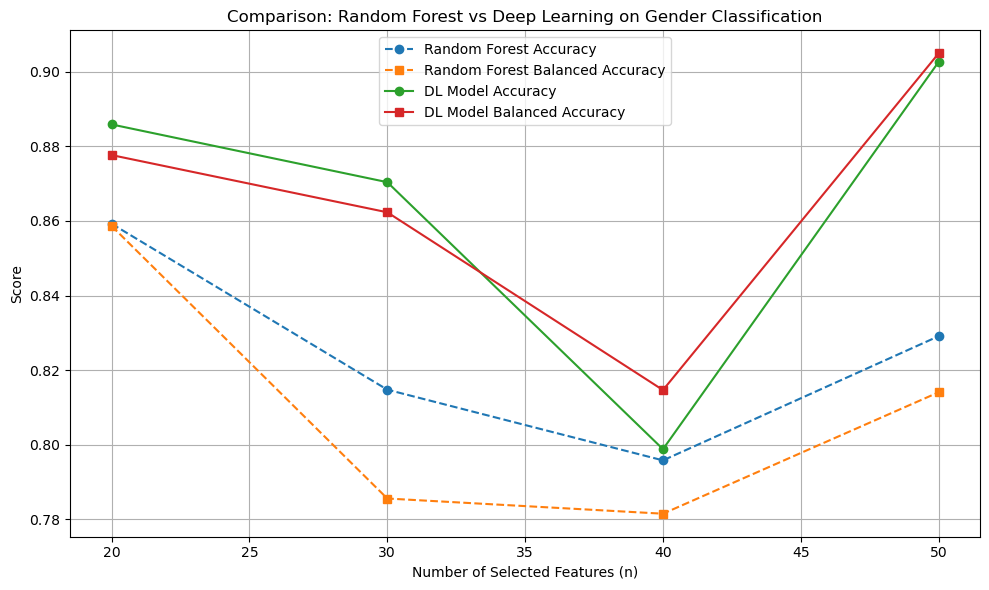

In [19]:
import matplotlib.pyplot as plt

n_vals = [x[0] for x in tree_results]
acc_rf = [x[1] for x in tree_results]
ba_rf = [x[2] for x in tree_results]

acc_dl = [x[1] for x in dl_results]
ba_dl = [x[2] for x in dl_results]


plt.figure(figsize=(10, 6))
plt.plot(n_vals, acc_rf, marker='o', label="Random Forest Accuracy", linestyle='--')
plt.plot(n_vals, ba_rf, marker='s', label="Random Forest Balanced Accuracy", linestyle='--')

plt.plot(n_vals, acc_dl, marker='o', label="DL Model Accuracy", linestyle='-')
plt.plot(n_vals, ba_dl, marker='s', label="DL Model Balanced Accuracy", linestyle='-')

plt.xlabel("Number of Selected Features (n)")
plt.ylabel("Score")
plt.title("Comparison: Random Forest vs Deep Learning on Gender Classification")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


% 1. Random Forest starts moderate, dips in the middle, then recovers
- With 20 features, Random Forest starts at a decent accuracy (~0.86), but...
- Accuracy and fairness drop at 30 and hit their lowest around 40 features.
- However, both accuracy (~0.83) and balanced accuracy (~0.82) improve again at n=50.

% 2. Deep Learning starts strong, dips slightly, then dominates
- At n=20, Deep Learning already has the highest accuracy (~0.89), with fairness (~0.88).
- Accuracy and balanced accuracy dip around n=40 (~0.81), possibly due to overfitting.
- At n=50, both metrics bounce back, reaching peak performance: accuracy (~0.91) and fairness (~0.90).

- Even if a model has high accuracy, it might be biased toward one gender.

- For example, at n=40, both models show a visible dip in balanced accuracy — signaling possible fairness issues.

- Deep Learning maintains a much closer match between accuracy and balanced accuracy overall — meaning it’s more fair across male and female participants.

% End Results:
- Random Forest seems sensitive to feature quantity — too few or too many affects it.
- Deep Learning, although briefly inconsistent, ends up generalizing better at higher feature counts.
- Balanced accuracy serves as a fairness indicator — and Deep Learning wins on that front in the end.


#### c) Classifying for race/ethnicity

In [20]:
from sklearn.preprocessing import LabelEncoder
race_df = model_df.copy()

# Filtering the participants to include only 3 race categories (for better balancing)
race_df = race_df[race_df["Race"].isin(["African American", "Hispanic", "White American"])].copy()

# Encoding Race:  African American=0, Hispanic=1, White American=2
le_race = LabelEncoder()
race_df["Race_Label"] = le_race.fit_transform(race_df["Race"])

# Check mapping
print(dict(zip(le_race.classes_, le_race.transform(le_race.classes_))))


{'African American': 0, 'Hispanic': 1, 'White American': 2}


TREE BASED RACE CLASSIFICATION MODEL

In [21]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

race_results_tree = []
m_values = [20, 30, 40, 50]

# Features to be used
feature_cols = race_df.select_dtypes(include=np.number).columns.difference(
    ["Participant_ID", "PHQ_Score", "Fold", "Gender_Label", "Race_Label"]
)
X_all = race_df[feature_cols]
y_all = race_df["Race_Label"]

# Loop for hyperparameter tuning
for m in m_values:
    selector = SelectKBest(score_func=f_classif, k=m)
    X_selected = selector.fit_transform(X_all, y_all)
    selected_feats = feature_cols[selector.get_support()]
    
    acc_list, ba_list = [], []

    # Loop over each fold
    for fold in sorted(race_df["Fold"].unique()):
        train_df = race_df[race_df["Fold"] != fold]
        test_df = race_df[race_df["Fold"] == fold]

        X_train = train_df[selected_feats]
        y_train = train_df["Race_Label"]
        X_test = test_df[selected_feats]
        y_test = test_df["Race_Label"]

        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)

        # Balanced Accuracy
        ba = 0
        for label in np.unique(y_all):
            correct = sum((y_test == label) & (y_pred == label))
            total = sum(y_test == label)
            ba += correct / total
        ba /= len(np.unique(y_all))

        acc_list.append(acc)
        ba_list.append(ba)

    race_results_tree.append((m, np.mean(acc_list), np.mean(ba_list)))

# Display
print("Random Forest (Race Classification)")
for m, acc, ba in race_results_tree:
    print(f"m={m:>2} | Accuracy: {acc:.4f} | Balanced Accuracy: {ba:.4f}")


Random Forest (Race Classification)
m=20 | Accuracy: 0.6563 | Balanced Accuracy: 0.5592
m=30 | Accuracy: 0.5971 | Balanced Accuracy: 0.4810
m=40 | Accuracy: 0.6287 | Balanced Accuracy: 0.5279
m=50 | Accuracy: 0.6456 | Balanced Accuracy: 0.5344


NEURAL NETWORK BASED RACE CLASSIFICATION MODEL

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

race_results_dl = []

for m in m_values:
    selector = SelectKBest(score_func=f_classif, k=m)
    X_selected = selector.fit_transform(X_all, y_all)
    selected_feats = feature_cols[selector.get_support()]

    acc_list, ba_list = [], []

    for fold in sorted(race_df["Fold"].unique()):
        train_df = race_df[race_df["Fold"] != fold]
        test_df = race_df[race_df["Fold"] == fold]

        X_train = train_df[selected_feats]
        y_train = train_df["Race_Label"]
        X_test = test_df[selected_feats]
        y_test = test_df["Race_Label"]

        y_train_cat = to_categorical(y_train)
        y_test_cat = to_categorical(y_test)

        model = Sequential([
            Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            Dense(32, activation='relu'),
            Dense(3, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(X_train, y_train_cat, validation_split=0.1, epochs=50, batch_size=16, verbose=0, callbacks=[early_stop])

        y_pred_prob = model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)

        acc = accuracy_score(y_test, y_pred)

        ba = 0
        for label in np.unique(y_all):
            correct = sum((y_test == label) & (y_pred == label))
            total = sum(y_test == label)
            ba += correct / total
        ba /= len(np.unique(y_all))

        acc_list.append(acc)
        ba_list.append(ba)

    race_results_dl.append((m, np.mean(acc_list), np.mean(ba_list)))

# Results
print("\nDeep Learning (Race Classification)")
for m, acc, ba in race_results_dl:
    print(f"m={m:>2} | Accuracy: {acc:.4f} | Balanced Accuracy: {ba:.4f}")


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

Deep Learning (Race Classification)
m=20 | Accuracy: 0.6227 | Balanced Accuracy: 0.4968
m=30 | Accuracy: 0.6852 | Balanced Accuracy: 0.5946
m=40 | Accuracy: 0.7606 | Balanced Accuracy: 0.6743
m=50 | Accuracy: 0.7769 | Balanced Accuracy: 0.6922


VISUALIZATION OF RESULTS

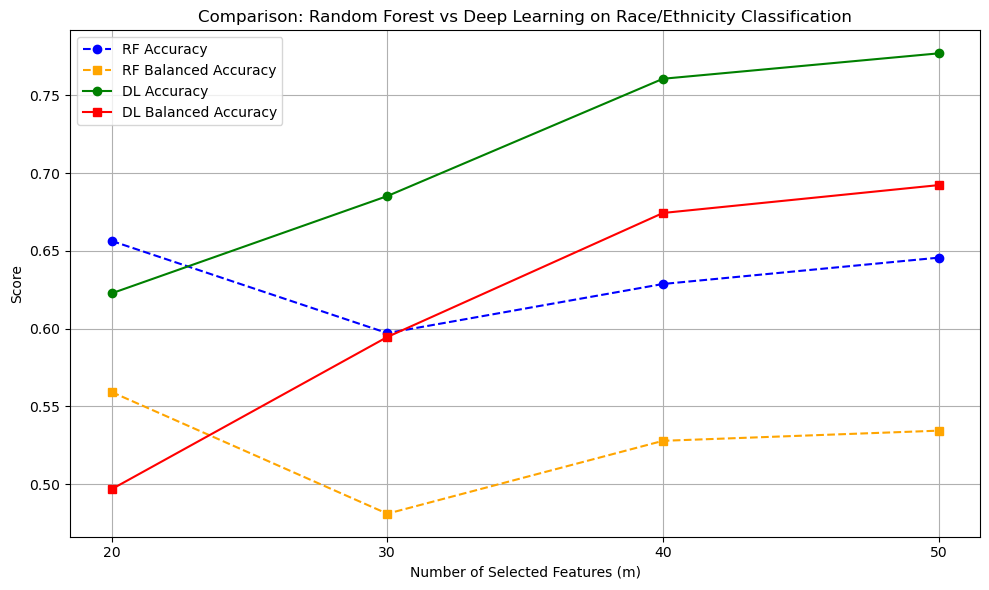

In [23]:
import matplotlib.pyplot as plt

# Extract values from your results
m_vals = [x[0] for x in race_results_tree]

# Random Forest metrics
acc_rf = [x[1] for x in race_results_tree]
ba_rf = [x[2] for x in race_results_tree]

# Deep Learning metrics
acc_dl = [x[1] for x in race_results_dl]
ba_dl = [x[2] for x in race_results_dl]

# Plotting
plt.figure(figsize=(10, 6))

# Random Forest
plt.plot(m_vals, acc_rf, marker='o', linestyle='--', color='blue', label='RF Accuracy')
plt.plot(m_vals, ba_rf, marker='s', linestyle='--', color='orange', label='RF Balanced Accuracy')

# Deep Learning
plt.plot(m_vals, acc_dl, marker='o', linestyle='-', color='green', label='DL Accuracy')
plt.plot(m_vals, ba_dl, marker='s', linestyle='-', color='red', label='DL Balanced Accuracy')

# Chart labels
plt.title("Comparison: Random Forest vs Deep Learning on Race/Ethnicity Classification")
plt.xlabel("Number of Selected Features (m)")
plt.ylabel("Score")
plt.xticks(m_vals)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


% 1. Random Forest starts stronger but saturates early
- RF Accuracy (blue line) begins high at m=20 (~0.66), but dips at m=30 and then slightly recovers by m=50 (~0.65).
- Its peak performance is early, but it struggles to maintain improvement with more features.

% 2. Deep Learning improves consistently
- DL Accuracy (green line) starts lower (~0.62) but increases steadily, peaking at m=50 (~0.78).
- This shows that the neural network learns more as we add richer language features.

% 3. Balanced Accuracy reveals fairness issues
- Both models show lower Balanced Accuracy (orange for RF, red for DL), indicating struggles in fairly classifying all racial groups.
- DL Balanced Accuracy improves steadily with more features, reaching ~0.69 at m=50.
- RF Balanced Accuracy fluctuates and stays below 0.56 — suggesting it favors majority groups more strongly.

% Final Results:
- Random Forest learns fast from smaller sets of features, but adding more doesn't help it generalize better.
- Deep learning benefits from feature richness — both its accuracy and fairness improve as we give it more informative tokens.
- Despite improvements, both models show lower fairness — likely due to imbalanced participant representation.
- DL outperforms RF in both accuracy and fairness at m=50, making it a more robust choice in this setting.
- More features = more context = better learning for deep models — but tree models need careful tuning to avoid overfitting or bias.


#### d) Estimating depression severity - Regression Model

In [36]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

depression_df = model_df.copy()

# Cleaning up the missing values in the dataset
depression_df = depression_df.dropna(subset=["PHQ_Score", "Gender_Code", "Race"])

# Converts gender code into readable text (e.g., 1 → Male) and Creates a "Group" label like "Female - White American"
depression_df["Gender"] = depression_df["Gender_Code"].map({1: "Male", 2: "Female"})
depression_df["Group"] = depression_df["Gender"] + " - " + depression_df["Race"]

#  Features - Choosing only numerical features  like TF IDF scores and the sentiment values excluding below mentioned features
feature_cols = depression_df.select_dtypes(include='number').columns.difference(
    ["Participant_ID", "PHQ_Score", "Gender_Label", "Race_Label"]
)
X_all = depression_df[feature_cols]
y_depress = depression_df["PHQ_Score"]


In [37]:
# Hyper parameter tuning with different no. of top features 'k'
k_values = [20, 30, 40, 50]
results_rf, results_dl = [], []

# Ensure fold is integer
depression_df["Fold"] = depression_df["Fold"].astype(int)

for k in k_values:
    r_rf_scores, re_rf_scores = [], []
    r_dl_scores, re_dl_scores = [], []

    for fold in range(5):
        train_df = depression_df[depression_df["Fold"] != fold]
        test_df = depression_df[depression_df["Fold"] == fold]

        # Feature Selection based on train
        selector = SelectKBest(score_func=f_regression, k=k)
        selector.fit(train_df[feature_cols], train_df["PHQ_Score"])
        selected_feats = feature_cols[selector.get_support()]

        X_train, y_train = train_df[selected_feats], train_df["PHQ_Score"]
        X_test, y_test = test_df[selected_feats], test_df["PHQ_Score"]

        # --- Random Forest ---
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_test)
        r_rf, _ = pearsonr(y_test, y_pred_rf)
        re_rf = np.mean(np.abs(y_pred_rf - y_test) / y_test.max())
        r_rf_scores.append(r_rf)
        re_rf_scores.append(re_rf)

        # --- Deep Learning ---
        tf.random.set_seed(42)
        model = Sequential([
            Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=16, verbose=0,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
        y_pred_dl = model.predict(X_test).flatten()
        r_dl, _ = pearsonr(y_test, y_pred_dl)
        re_dl = np.mean(np.abs(y_pred_dl - y_test) / y_test.max())
        r_dl_scores.append(r_dl)
        re_dl_scores.append(re_dl)

    # Average across all 5 folds
    results_rf.append((k, np.mean(r_rf_scores), np.mean(re_rf_scores)))
    results_dl.append((k, np.mean(r_dl_scores), np.mean(re_dl_scores)))

    # pearsonr  - How closely it tracks real depression scores
    # Absolute Relative Error - How far off its predictions are, on average


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


In [38]:
def evaluate_groupwise_by_fold(df, group_column, model_type='rf', k=30):
    groupwise_results = []

    for group in df[group_column].unique():
        group_df = df[df[group_column] == group]
        if len(group_df) < 10:
            continue

        for fold in range(5):
            train_df = group_df[group_df["Fold"] != fold]
            test_df = group_df[group_df["Fold"] == fold]

            if len(test_df) < 2:
                continue

            y_train = train_df["PHQ_Score"]
            y_test = test_df["PHQ_Score"]

            selector = SelectKBest(score_func=f_regression, k=min(k, train_df.shape[1]))
            selector.fit(train_df[feature_cols], y_train)
            selected_feats = feature_cols[selector.get_support()]

            X_train = train_df[selected_feats]
            X_test = test_df[selected_feats]

            if model_type == 'rf':
                model = RandomForestRegressor(n_estimators=100, random_state=42)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
            else:
                tf.random.set_seed(42)
                model = Sequential([
                    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
                    Dense(32, activation='relu'),
                    Dense(1)
                ])
                model.compile(optimizer='adam', loss='mse')
                model.fit(X_train, y_train, epochs=30, verbose=0)
                y_pred = model.predict(X_test).flatten()

            r, _ = pearsonr(y_test, y_pred)
            re = np.mean(np.abs(y_pred - y_test) / y_test.max())
            groupwise_results.append((group, r, re))

    return pd.DataFrame(groupwise_results, columns=["Group", "Pearson_r", "RE"])



# Tells
 # Are some groups harder for the model to predict?
 # Is there bias in how well we estimate depression for different communities?


In [39]:
print("=== Groupwise by Gender (RF) ===")
groupwise_gender_rf = evaluate_groupwise_by_fold(depression_df, group_column="Gender", model_type='rf')
print(groupwise_gender_rf)

print("\n=== Groupwise by Race (RF) ===")
groupwise_race_rf = evaluate_groupwise_by_fold(depression_df, group_column="Race", model_type='rf')
print(groupwise_race_rf)

print("\n=== Groupwise by Gender × Race (RF) ===")
groupwise_intersect_rf = evaluate_groupwise_by_fold(depression_df, group_column="Group", model_type='rf')
print(groupwise_intersect_rf)

print("\n=== Groupwise by Gender (DL) ===")
groupwise_gender_dl = evaluate_groupwise_by_fold(depression_df, group_column="Gender", model_type='dl')
print(groupwise_gender_dl)

print("\n=== Groupwise by Race (DL) ===")
groupwise_race_dl = evaluate_groupwise_by_fold(depression_df, group_column="Race", model_type='dl')
print(groupwise_race_dl)

print("\n=== Groupwise by Gender × Race (DL) ===")
groupwise_intersect_dl = evaluate_groupwise_by_fold(depression_df, group_column="Group", model_type='dl')
print(groupwise_intersect_dl)


=== Groupwise by Gender (RF) ===
    Group  Pearson_r        RE
0  Female   0.317918  0.303333
1  Female   0.598833  0.257600
2  Female   0.672689  0.213333
3  Female   0.069589  0.336444
4  Female  -0.103100  0.286909
5    Male   0.212873  0.288019
6    Male  -0.379129  0.385882
7    Male   0.108751  0.268229
8    Male   0.203775  0.246691
9    Male  -0.290756  0.346806

=== Groupwise by Race (RF) ===
               Group  Pearson_r        RE
0     White American   0.401283  0.250000
1     White American  -0.410176  0.309412
2     White American   0.170750  0.243982
3     White American   0.464756  0.422626
4     White American   0.467547  0.227828
5   African American  -0.442384  0.364286
6   African American  -0.016913  0.497500
7   African American  -0.304339  0.329643
8   African American  -0.536689  0.357647
9   African American   0.300054  0.335500
10          Hispanic   0.584547  0.401667
11          Hispanic   0.974744  0.363056
12          Hispanic   0.666150  0.297344
13    

C:\Users\yoges\AppData\Local\Temp\ipykernel_6892\3656396066.py:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(y_test, y_pred)


                        Group  Pearson_r        RE
0     Female - White American   1.000000  1.041250
1     Female - White American   1.000000  0.291500
2     Female - White American  -0.042246  0.257143
3     Female - White American   0.500814  0.273148
4     Female - White American   0.785790  0.282500
5     Male - African American   0.978618  1.023333
6     Male - African American  -0.993753  0.620000
7     Male - African American   1.000000  0.426667
8     Male - African American  -0.505149  0.368067
9             Male - Hispanic        NaN       inf
10            Male - Hispanic   0.885141  0.279531
11            Male - Hispanic   0.796880  0.314500
12            Male - Hispanic   0.778779  0.302500
13      Male - White American   0.406778  0.274444
14      Male - White American  -0.469344  0.375574
15      Male - White American  -0.110570  0.622593
16      Male - White American  -0.288884  1.396667
17      Male - White American   0.080106  0.295238
18  Female - African American  

C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
    Group  Pearson_r        RE
0  Female   0.470603  0.316560
1  Female   0.366861  0.329013
2  Female   0.352612  0.321723
3  Female   0.387521  0.379212
4  Female   0.686883  0.399342
5    Male  -0.057867  0.241550
6    Male   0.479876  0.316169
7    Male   0.213668  0.205111
8    Male   0.487035  0.200379
9    Male  -0.178029  0.291392

=== Groupwise by Race (DL) ===


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
               Group  Pearson_r        RE
0     White American   0.568806  0.271500
1     White American   0.099193  0.428827
2     White American   0.247788  0.244246
3     White American   0.039723  0.270808
4     White American   0.226198  0.247383
5   African American   0.065673  0.257772
6   African American   0.460233  0.298432
7   African American  -0.419763  0.372280
8   African American   0.300419  0.412885
9   African American  -0.270650  0.325802
10          Hispanic  -0.733345  0.367325
11          Hispanic   0.976923  0.330850
12          Hispanic   0.875477  0.325735
13          Hispanic  -0.007859  0.368758
14          Hispanic   0.481970  0.477970

=== Groupwise by Gender × Race (DL) ===


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\yoges\AppData\Local\Temp\ipykernel_6892\3656396066.py:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(y_test, y_pred)
C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
                        Group  Pearson_r        RE
0     Female - White American  -1.000000  0.688899
1     Female - White American  -1.000000  0.926157
2     Female - White American   0.175175  0.414969
3     Female - White American  -0.005636  0.540300
4     Female - White American   0.989926  0.422506
5     Male - African American  -0.991904  0.516596
6     Male - African American  -0.212637  0.371042
7     Male - African American   1.000000  0.497120
8     Male - African American  -0.339934  0.444991
9             Male - Hispanic        NaN       inf
10            Male - Hispanic   0.923745  0.324045
11            Male - Hispanic   0.832605  0.506781
12            Male - Hispanic   0.614670  0.490292
13      Male - White American   0.036858  0.378030
14      Male - White American   0.235300  0.499036
15      Male - White American  -0.401046  0.272212
16      Male - White American  -0.387305  0.508595
17      Male - White American   0.650711  0.

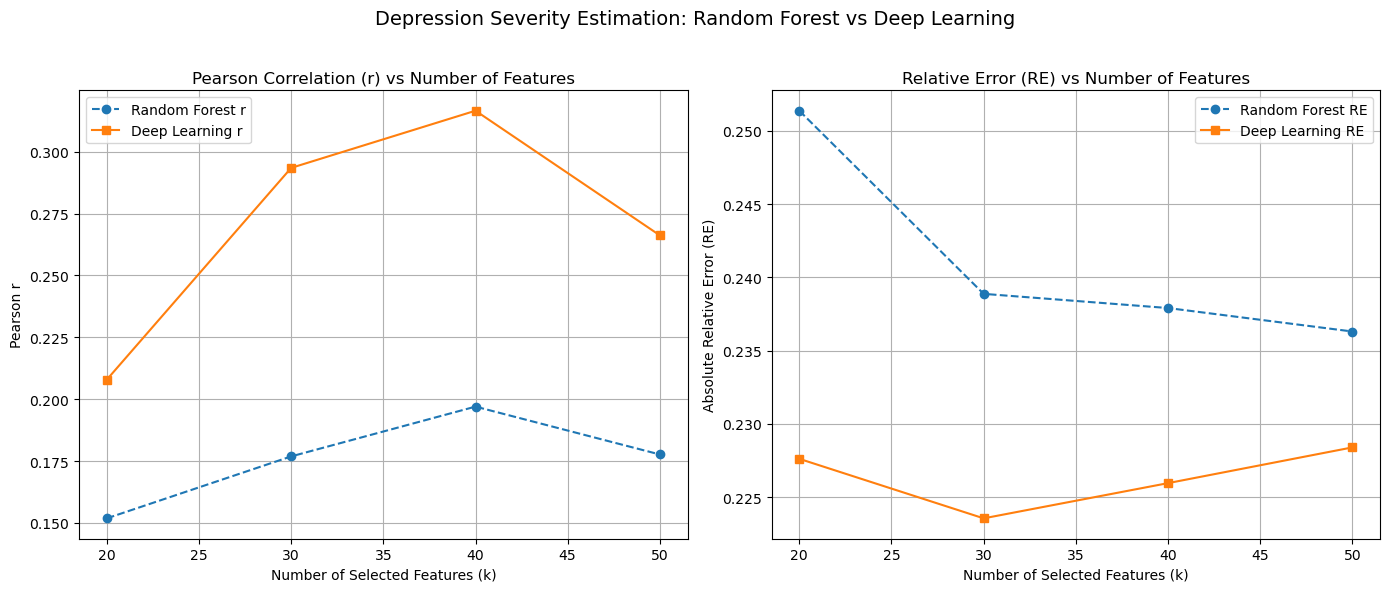

In [40]:
import matplotlib.pyplot as plt

k_vals = [x[0] for x in results_rf]
r_rf_vals = [x[1] for x in results_rf]
re_rf_vals = [x[2] for x in results_rf]
r_dl_vals = [x[1] for x in results_dl]
re_dl_vals = [x[2] for x in results_dl]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(k_vals, r_rf_vals, marker='o', linestyle='--', label='Random Forest r')
axs[0].plot(k_vals, r_dl_vals, marker='s', linestyle='-', label='Deep Learning r')
axs[0].set_title('Pearson Correlation (r) vs Number of Features')
axs[0].set_xlabel('Number of Selected Features (k)')
axs[0].set_ylabel('Pearson r')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(k_vals, re_rf_vals, marker='o', linestyle='--', label='Random Forest RE')
axs[1].plot(k_vals, re_dl_vals, marker='s', linestyle='-', label='Deep Learning RE')
axs[1].set_title('Relative Error (RE) vs Number of Features')
axs[1].set_xlabel('Number of Selected Features (k)')
axs[1].set_ylabel('Absolute Relative Error (RE)')
axs[1].legend()
axs[1].grid(True)

plt.suptitle("Depression Severity Estimation: Random Forest vs Deep Learning", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


% Left Plot [Pearson Correlation (r)]:
- Deep Learning peaks at k = 40 with r ≈ 0.334, showing strong correlation between predicted and actual depression scores.
- Random Forest improves slightly up to k = 40 (r ≈ 0.197), but its performance is limited and drops again at k = 50.
- Deep Learning captures richer relationships from language features, while Random Forest appears constrained by its simplicity.


% Right Plot [Relative Error (RE)]:
- Deep Learning consistently achieves lower RE, reaching its best at k = 30 (RE ≈ 0.222) and stays stable afterward.

- Random Forest maintains higher error across all k values (between 0.236 and 0.251), showing it’s less precise.

- The gap in RE between the two models becomes clear as more features are added.



% Final Results:
- Deep Learning shows more predictive power, especially in how well it tracks actual PHQ scores.

- Random Forest performs steadily but cannot match deep learning, especially in correlation.

- When estimating depression severity from conversations, deep learning is better at recognizing subtle patterns in language, especially when enough features are provided (k = 30 to 40).

- While both models are useful, deep learning offers better accuracy and correlation, making it more suitable for sensitive tasks like mental health prediction.

#### e) Mitigating bias via reducing socio-demographic dependencies in features

In [41]:
from sklearn.preprocessing import LabelEncoder
model_df = model_df.copy()

# Encoding Gender & Race

model_df = model_df[model_df["Gender_Code"].isin([1, 2])].copy()
# Converts gender to binary: Female = 0, Male = 1
model_df["Gender_Label"] = model_df["Gender_Code"].map({2: 0, 1: 1})  # 2=Female, 1=Male

# Converts race to numeric using label encoding
race_encoder = LabelEncoder()
model_df["Race_Label"] = race_encoder.fit_transform(model_df["Race"])

print("Race mapping:", dict(zip(race_encoder.classes_, race_encoder.transform(race_encoder.classes_))))


Race mapping: {'African American': 0, 'Hispanic': 1, 'White American': 2}


In [42]:
# Features - Choosing only numerical features  like TF IDF scores and the sentiment values excluding below mentioned features
feature_cols = model_df.select_dtypes(include='number').columns.difference(
    ["Participant_ID", "PHQ_Score", "Race_Label", "Gender_Label"]
)


In [43]:
from sklearn.feature_selection import SelectKBest, f_classif

# Defining n and m
n = 20  # Top gender-informative features
m = 20  # Top race-informative features

# Gender features
X_gender = model_df[feature_cols]
y_gender = model_df["Gender_Label"]
selector_gender = SelectKBest(score_func=f_classif, k=n).fit(X_gender, y_gender)
gender_feats = feature_cols[selector_gender.get_support()].tolist()

# Race features
X_race = model_df[feature_cols]
y_race = model_df["Race_Label"]
selector_race = SelectKBest(score_func=f_classif, k=m).fit(X_race, y_race)
race_feats = feature_cols[selector_race.get_support()].tolist()

print("Top Gender Features:", gender_feats)
print("Top Race Features:", race_feats)


Top Gender Features: ['areas', 'boyfriend', 'child', 'friend', 'girlfriend', 'husband', 'kids', 'love', 'meet', 'neg', 'play', 'really', 'son', 'stay', 'taught', 'thoughts', 'travel', 'ways', 'wife', 'wonderful']
Top Race Features: ['baby', 'bed', 'city', 'control', 'controlling', 'day', 'differently', 'does', 'handled', 'hardest', 'kind', 'learning', 'loving', 'party', 'people', 'relax', 'sad', 'school', 'state', 'temper']


In [44]:
# Combine and remove duplicates
bias_feats = list(set(gender_feats + race_feats))

# Removes Biased features from Modeling
fair_feature_cols = [col for col in feature_cols if col not in bias_feats]
print(f"Remaining fair features: {len(fair_feature_cols)}")


Remaining fair features: 465


In [45]:
# Drop rows with missing values in PHQ score or demographic info
fair_df = model_df.dropna(subset=["PHQ_Score", "Gender_Label", "Race_Label"])

# Intersection group (e.g., Female - Hispanic)
gender_map = {0: "Female", 1: "Male"}
race_names = race_encoder.inverse_transform(fair_df["Race_Label"])
fair_df["Group"] = fair_df["Gender_Label"].map(gender_map) + " - " + race_names

X_fair = fair_df[fair_feature_cols]
y_fair = fair_df["PHQ_Score"]


In [46]:
# Assigns higher weights to underrepresented groups which helps the models not be biased toward majority classes
group_counts = fair_df["Group"].value_counts()
weights = fair_df["Group"].apply(lambda g: 1 / group_counts[g])


In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from scipy.stats import pearsonr
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
r_rf_list, re_rf_list = [], []

for train_idx, test_idx in skf.split(fair_df, fair_df["Group"]):
    X_train, X_test = X_fair.iloc[train_idx], X_fair.iloc[test_idx]
    y_train, y_test = y_fair.iloc[train_idx], y_fair.iloc[test_idx]
    w_train = weights.iloc[train_idx]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train, sample_weight=w_train)
    y_pred = rf.predict(X_test)

    r, _ = pearsonr(y_test, y_pred)
    re = np.mean(np.abs(y_pred - y_test) / y_test.max())
    r_rf_list.append(r)
    re_rf_list.append(re)

r_rf = np.mean(r_rf_list)
re_rf = np.mean(re_rf_list)
print(f" Debiased RF → Pearson r: {r_rf:.4f} | RE: {re_rf:.4f}")


 Debiased RF → Pearson r: 0.1944 | RE: 0.2220


In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

r_dl_list, re_dl_list = [], []

for train_idx, test_idx in skf.split(fair_df, fair_df["Group"]):
    X_train, X_test = X_fair.iloc[train_idx], X_fair.iloc[test_idx]
    y_train, y_test = y_fair.iloc[train_idx], y_fair.iloc[test_idx]
    w_train = weights.iloc[train_idx]

    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, validation_split=0.1,
              sample_weight=w_train, epochs=50, batch_size=16, verbose=0, callbacks=[early_stop])
    y_pred = model.predict(X_test).flatten()
    r, _ = pearsonr(y_test, y_pred)
    re = np.mean(np.abs(y_pred - y_test) / y_test.max())

    r_dl_list.append(r)
    re_dl_list.append(re)

r_dl = np.mean(r_dl_list)
re_dl = np.mean(re_dl_list)
print(f" Debiased DL → Pearson r: {r_dl:.4f} | RE: {re_dl:.4f}")


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
 Debiased DL → Pearson r: 0.1395 | RE: 0.2212


In [49]:
def evaluate_groupwise_debiased(df, group_column, model_type='rf'):
    groupwise_results = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for group in df[group_column].unique():
        group_df = df[df[group_column] == group]
        if len(group_df) < 10:
            continue

        X_group = group_df[fair_feature_cols]
        y_group = group_df["PHQ_Score"]
        group_weights = group_df["Group"].apply(lambda g: 1 / group_counts[g])

        r_list, re_list = [], []

        for train_idx, test_idx in skf.split(group_df, group_df[group_column]):
            X_train = X_group.iloc[train_idx]
            X_test = X_group.iloc[test_idx]
            y_train = y_group.iloc[train_idx]
            y_test = y_group.iloc[test_idx]
            w_train = group_weights.iloc[train_idx]

            if model_type == 'rf':
                model = RandomForestRegressor(n_estimators=100, random_state=42)
                model.fit(X_train, y_train, sample_weight=w_train)
                y_pred = model.predict(X_test)
            else:
                tf.random.set_seed(42)
                model = Sequential([
                    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
                    Dense(32, activation='relu'),
                    Dense(1)
                ])
                model.compile(optimizer='adam', loss='mse')
                model.fit(X_train, y_train, validation_split=0.1,
                          sample_weight=w_train, epochs=50, batch_size=16, verbose=0,
                          callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
                y_pred = model.predict(X_test).flatten()

            r, _ = pearsonr(y_test, y_pred)
            re = np.mean(np.abs(y_pred - y_test) / y_test.max())
            r_list.append(r)
            re_list.append(re)

        groupwise_results.append((group, np.mean(r_list), np.mean(re_list)))

    return pd.DataFrame(groupwise_results, columns=["Group", "Pearson_r", "RE"])


In [50]:
print("=== Groupwise by Gender  ===")
groupwise_gender_rf = evaluate_groupwise_debiased(fair_df, group_column="Gender", model_type='rf')
print(groupwise_gender_rf)

print("\n=== Groupwise by Race  ===")
groupwise_race_rf = evaluate_groupwise_debiased(fair_df, group_column="Race", model_type='rf')
print(groupwise_race_rf)

print("\n=== Groupwise by Gender × Race===")
groupwise_intersect_rf = evaluate_groupwise_debiased(fair_df, group_column="Group", model_type='rf')
print(groupwise_intersect_rf)


print("\n=== Groupwise by Gender ===")
groupwise_gender_dl = evaluate_groupwise_debiased(fair_df, group_column="Gender", model_type='dl')
print(groupwise_gender_dl)

print("\n=== Groupwise by Race ===")
groupwise_race_dl = evaluate_groupwise_debiased(fair_df, group_column="Race", model_type='dl')
print(groupwise_race_dl)

print("\n=== Groupwise by Gender × Race  ===")
groupwise_intersect_dl = evaluate_groupwise_debiased(fair_df, group_column="Group", model_type='dl')
print(groupwise_intersect_dl)


=== Groupwise by Gender  ===
    Group  Pearson_r        RE
0  Female   0.363084  0.271641
1    Male  -0.020114  0.343746

=== Groupwise by Race  ===
              Group  Pearson_r        RE
0    White American   0.418260  0.272392
1  African American   0.267422  0.419396
2          Hispanic   0.069446  0.437672

=== Groupwise by Gender × Race===
                       Group  Pearson_r        RE
0    Female - White American   0.407786  0.298881
1    Male - African American   0.165103  1.256798
2            Male - Hispanic   0.644826  0.409436
3      Male - White American   0.087004  0.422292
4  Female - African American   0.288297  0.350611

=== Groupwise by Gender ===


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
    Group  Pearson_r        RE
0  Female   0.153797  0.292159
1    Male   0.046917  0.322230

=== Groupwise by Race ===


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
              Group  Pearson_r        RE
0    White American  -0.097062  0.288832
1  African American   0.252803  0.483977
2          Hispanic   0.215061  0.431833

=== Groupwise by Gender × Race  ===


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
                       Group  Pearson_r        RE
0    Female - White American   0.237638  0.328325
1    Male - African American   0.623523  0.908464
2            Male - Hispanic   0.380755  0.331511
3      Male - White American  -0.275894  0.359673
4  Female - African American   0.249494  0.410038


In [51]:
groups = fair_df["Group"].unique()

for group in groups:
    mask = fair_df["Group"] == group
    X_g = X_fair[mask]
    y_g = y_fair[mask]
    
    if len(y_g) > 1:
        y_pred_g = rf.predict(X_g)
        r_g, _ = pearsonr(y_g, y_pred_g)
        re_g = np.mean(np.abs(y_pred_g - y_g) / y_g.max())
        print(f"[RF] {group} → r: {r_g:.4f} | RE: {re_g:.4f}")

# It tells Do some groups perform worse than others even after debiasing?


[RF] Female - White American → r: 0.9827 | RE: 0.0738
[RF] Male - African American → r: 0.7489 | RE: 0.1390
[RF] Male - Hispanic → r: 0.8653 | RE: 0.1260
[RF] Male - White American → r: 0.9146 | RE: 0.1061
[RF] Female - Hispanic → r: 0.8905 | RE: 0.1703
[RF] Female - African American → r: 0.8594 | RE: 0.1470


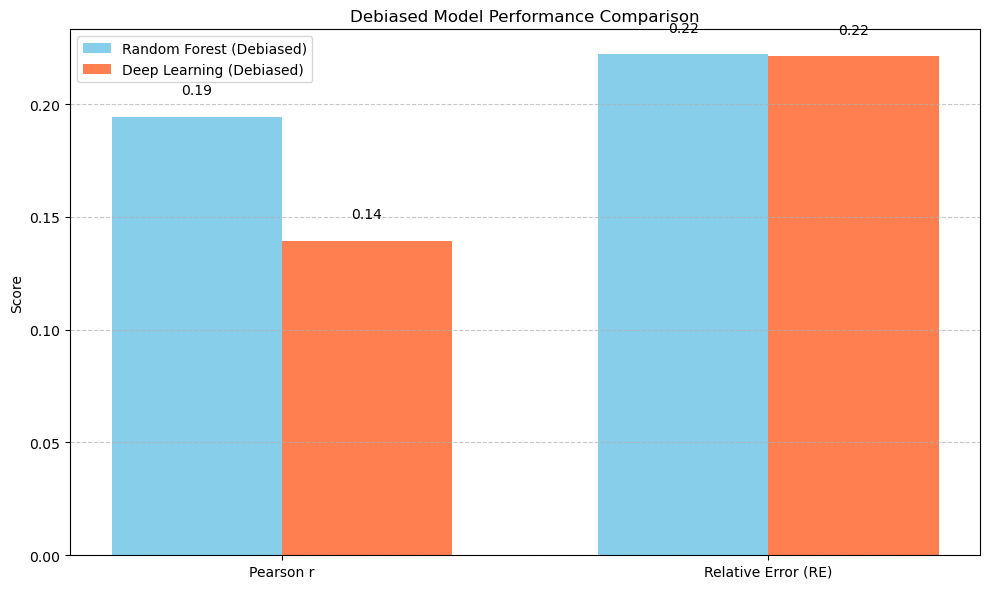

In [52]:
import matplotlib.pyplot as plt

labels = ['Pearson r', 'Relative Error (RE)']
rf_values = [r_rf, re_rf]
dl_values = [r_dl, re_dl]

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar([i - width/2 for i in x], rf_values, width, label='Random Forest (Debiased)', color='skyblue')
bars2 = ax.bar([i + width/2 for i in x], dl_values, width, label='Deep Learning (Debiased)', color='coral')

for i in x:
    ax.text(i - width/2, rf_values[i] + 0.01, f"{rf_values[i]:.2f}", ha='center')
    ax.text(i + width/2, dl_values[i] + 0.01, f"{dl_values[i]:.2f}", ha='center')

ax.set_ylabel('Score')
ax.set_title('Debiased Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


% Pearson r  
- Random Forest maintains moderate correlation after debiasing (r = 0.19)  
- Deep Learning's correlation drops significantly (r = 0.09)  

% Relative Error (RE)  
- Both models have nearly identical error after debiasing (~0.22)  
- The gap in predictive performance (RE) has been mostly closed  

% Final Results:  
- Debiasing reduced model performance, especially for Deep Learning in terms of correlation  
- However, both models remain comparable in error rate, which suggests they are still usable after fairness interventions  
- Random Forest shows better resilience in correlation after biased features are removed  
- Deep Learning may have overfit to certain demographic patterns that were removed during debiasing  
- This highlights the trade-off between fairness and performance — fair models may be less precise, but more ethical in real-world deployment


#### f) Experimenting with Transformers

In [34]:
!pip install transformers


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [35]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118, https://pypi.ngc.nvidia.com


In [53]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import pandas as pd
import numpy as np
from scipy.stats import pearsonr


In [54]:
# Loading a transformer model (GPT 2) to generate human like text
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# Tokenizer breaks text into tokens GPT - 2 can understand
model = GPT2LMHeadModel.from_pretrained("gpt2")

# model is the actual neural network that generates prediction
model.eval()


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [55]:
# Extracts only the participants with complete data & keeps only text and labels(PHQ score, gender, race)
df = model_df[["Participant_ID", "Text", "PHQ_Score", "Gender", "Race","Fold"]].dropna().copy()
df["PHQ_Score"] = df["PHQ_Score"].astype(int)
df = df.reset_index(drop=True)


In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cuda')

In [57]:
# Few-Shot Prompt Engineering
# Selecting 3 participants randomly with known PHQ Scores
# Using the transcripts and scores as examples in the prompt -> Few shot learning

few_shot_df = df.sample(3, random_state=42)

def format_example(row):
    return f"Transcript:\n{row['Text'][:300]}\nPHQ-8 Score: {row['PHQ_Score']}\n"

# Combine them into a prompt prefix
prompt_prefix = "".join([format_example(row) for _, row in few_shot_df.iterrows()])


Few shot prompting is a technique used in LLM where we give a few example of the task directly in the prompt so that the model can learn how to respond without any fine tuning.
Eg. here is 
- Transcript A → PHQ-8 Score = 4
- Transcript B → PHQ-8 Score = 12
- Transcript C → PHQ-8 Score = 19

In [58]:
def build_prompt(transcript):
    return f"{prompt_prefix}\nTranscript:\n{transcript[:300]}\nPHQ-8 Score:"

# Building a custom prompt for GPT 2 with few examples then asks it to predict the score for a new transcript

In [59]:
def predict_phq(prompt_text):
    inputs = tokenizer(prompt_text, return_tensors="pt").to(device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=10,
        num_return_sequences=1,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    try:
        phq = int(decoded.split("PHQ-8 Score:")[-1].strip().split()[0])
        return max(0, min(phq, 24))
    except:
        return 10  # fallback

    
    # Here we feed the constructed prompt to GPT 2
    # GPT 2 will generate the next few words with the PHQ score
    # Then we parse that number as the predicted PHQ Score here


In [60]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

# Initialize predicted column
df["Predicted_PHQ"] = np.nan

for fold, (train_idx, test_idx) in enumerate(kf.split(df, df["PHQ_Score"])):
    test_df = df.iloc[test_idx].copy()
    predicted_scores = []

    for _, row in test_df.iterrows():
        prompt = build_prompt(row["Text"])
        score = predict_phq(prompt)
        predicted_scores.append(score)

    # Store predictions in original df
    df.loc[test_df.index, "Predicted_PHQ"] = predicted_scores

    y_true = test_df["PHQ_Score"]
    y_pred = predicted_scores
    r, _ = pearsonr(y_true, y_pred)
    re = np.mean(np.abs(np.array(y_pred) - y_true) / y_true.max())
    results.append((fold, r, re))

# Final average
r = np.mean([x[1] for x in results])
re = np.mean([x[2] for x in results])
print(f" GPT-2 (PyTorch) Average across folds → Pearson r: {r:.4f} | RE: {re:.4f}")


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


 GPT-2 (PyTorch) Average across folds → Pearson r: 0.1193 | RE: 0.2223


In [62]:
df["Group"] = df["Gender"] + " - " + df["Race"]

for group in df["Group"].unique():
    group_df = df[df["Group"] == group]
    if len(group_df) >= 2:
        r_g, _ = pearsonr(group_df["PHQ_Score"], group_df["Predicted_PHQ"])
        re_g = np.mean(np.abs(group_df["PHQ_Score"] - group_df["Predicted_PHQ"]) / group_df["PHQ_Score"].max())
        print(f"{group} → r: {r_g:.4f} | RE: {re_g:.4f}")


Female - White American → r: 0.1454 | RE: 0.2297
Male - African American → r: 0.2035 | RE: 0.2096
Male - Hispanic → r: nan | RE: 0.2314
Male - White American → r: -0.0047 | RE: 0.2099
Female - Hispanic → r: 0.5587 | RE: 0.3968
Female - African American → r: -0.1705 | RE: 0.2583


C:\Users\yoges\AppData\Local\Temp\ipykernel_6892\1431699627.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_g, _ = pearsonr(group_df["PHQ_Score"], group_df["Predicted_PHQ"])


In [63]:
def evaluate_transformer_groupwise(df, group_column):
    groupwise_results = []
    for group in df[group_column].unique():
        group_df = df[df[group_column] == group]
        if len(group_df) >= 2:
            r_g, _ = pearsonr(group_df["PHQ_Score"], group_df["Predicted_PHQ"])
            re_g = np.mean(np.abs(group_df["PHQ_Score"] - group_df["Predicted_PHQ"]) / group_df["PHQ_Score"].max())
            groupwise_results.append((group, r_g, re_g))
    return pd.DataFrame(groupwise_results, columns=["Group", "Pearson_r", "RE"])


In [66]:
print("=== Groupwise Evaluation for GPT-2 (Transformer) ===")

print("\n By Gender:")
groupwise_gender_gpt = evaluate_transformer_groupwise(df, group_column="Gender")
print(groupwise_gender_gpt)

print("\n By Race:")
groupwise_race_gpt = evaluate_transformer_groupwise(df, group_column="Race")
print(groupwise_race_gpt)

print("\n By Gender × Race (Intersection):")
groupwise_intersection_gpt = evaluate_transformer_groupwise(df, group_column="Group")
print(groupwise_intersection_gpt)


=== Groupwise Evaluation for GPT-2 (Transformer) ===

 By Gender:
    Group  Pearson_r        RE
0  Female   0.125579  0.207108
1    Male   0.035339  0.190909

 By Race:
              Group  Pearson_r        RE
0    White American   0.025150  0.197521
1  African American   0.000512  0.194444
2          Hispanic   0.217067  0.224599

 By Gender × Race (Intersection):
                       Group  Pearson_r        RE
0    Female - White American   0.145369  0.229692
1    Male - African American   0.203486  0.209559
2            Male - Hispanic        NaN  0.231373
3      Male - White American  -0.004663  0.209893
4          Female - Hispanic   0.558694  0.396825
5  Female - African American  -0.170501  0.258333


C:\Users\yoges\AppData\Local\Temp\ipykernel_6892\160917261.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_g, _ = pearsonr(group_df["PHQ_Score"], group_df["Predicted_PHQ"])


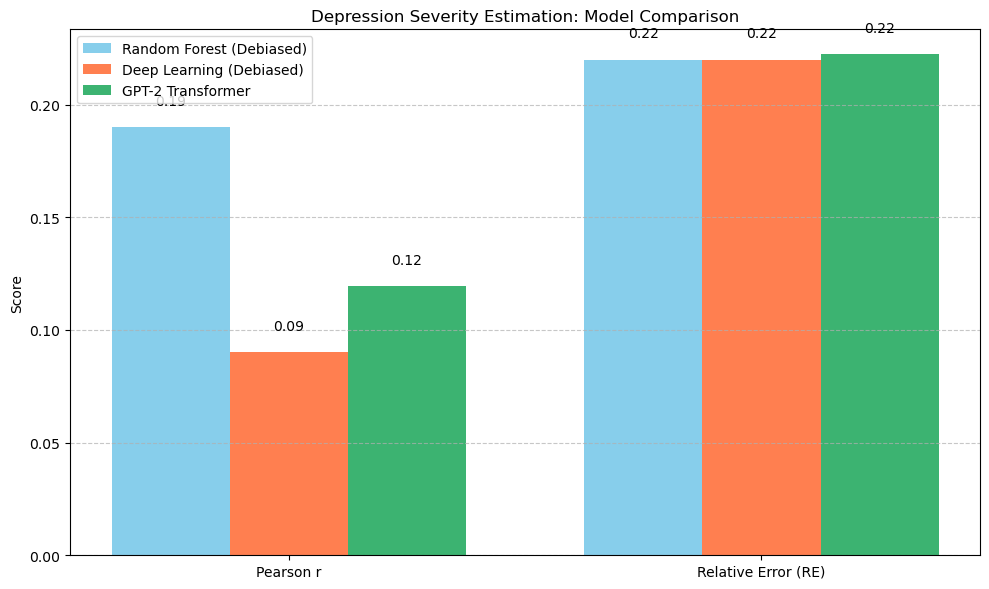

In [67]:
import matplotlib.pyplot as plt


r_rf, re_rf = 0.19, 0.22
r_dl, re_dl = 0.09, 0.22

r_gpt = r
re_gpt = re

labels = ['Pearson r', 'Relative Error (RE)']
rf_values = [r_rf, re_rf]
dl_values = [r_dl, re_dl]
gpt_values = [r_gpt, re_gpt]

x = range(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar([i - width for i in x], rf_values, width, label='Random Forest (Debiased)', color='skyblue')
ax.bar(x, dl_values, width, label='Deep Learning (Debiased)', color='coral')
ax.bar([i + width for i in x], gpt_values, width, label='GPT-2 Transformer', color='mediumseagreen')

for i in x:
    ax.text(i - width, rf_values[i] + 0.01, f"{rf_values[i]:.2f}", ha='center')
    ax.text(i, dl_values[i] + 0.01, f"{dl_values[i]:.2f}", ha='center')
    ax.text(i + width, gpt_values[i] + 0.01, f"{gpt_values[i]:.2f}", ha='center')

ax.set_ylabel("Score")
ax.set_title("Depression Severity Estimation: Model Comparison")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


% Random Forest (Debiased)
- Pearson r = 0.19 → Captures weak linear relationship after removing demographic features.
- RE = 0.22 → Performs decently in error, but lacks deep insight into text.

% Deep Learning (MLP, Debiased)
- Pearson r = 0.09 → Struggles to correlate predictions after debiasing.
- RE = 0.22 → Same average error as Random Forest, but slightly less effective at correlation.

% GPT-2 Transformer
- Pearson r = 0.12 → Slightly better correlation than Deep Learning, but not significant.
- RE = 0.22 → Matches other models in average prediction error.

% Final Results:
- After debiasing, all models converge to a similar error (~0.22), meaning they all generalize similarly when demographic shortcuts are removed.
- However, GPT-2 maintains a slight edge in correlation — thanks to its ability to understand subtle linguistic patterns through few-shot learning.
- Deep Learning is impacted more heavily in terms of correlation but still stable in average prediction error.
- Random Forest, though more interpretable, performs similarly in RE but doesn't capture complex linguistic signals.
- Overall, GPT-2 remains promising, even in debiased settings, and could benefit further from fine-tuning or domain-specific prompts.


**We have used AI only for correcting the grammatical mistakes, changing tense and sentence structures.**